## Dependencies

In [1]:
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from src_3d.model1 import MobileNetV3UNet3D
from torchsummary import summary
from ptflops import get_model_complexity_info
from torch.profiler import profile, record_function, ProfilerActivity
import torch
import math
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# -- Change this as per your data directory --#
data_path = Path('C:\Projects\python\echoframe\data\EchoNet-Dynamic\EchoNet-Dynamic\\')


file_list_path = os.path.join(data_path,'FileList.csv')
volume_tracings_path = os.path.join(data_path,'VolumeTracings.csv')
videos_path = os.path.join(data_path,'Videos')


model_path_1 = r'./models/pretrained_mobilenet_3d.pt'

model_path_2 = r'./models/pretrained_masked_mobilenet_3d.pt'

model_path_3 = r'./models/scratch_mobilenet_3d.pt'



In [2]:
file_list = pd.read_csv(filepath_or_buffer=file_list_path)
volume_tracings = pd.read_csv(filepath_or_buffer=volume_tracings_path)
file_list['FileName'] = file_list['FileName'].apply(
    lambda x: x if x.endswith('.avi') else x + '.avi'
)
vt_filenames = set(volume_tracings['FileName'])
fl_filenames = set(file_list['FileName'])

missing_files = list(fl_filenames - vt_filenames)
extra_files = list(vt_filenames - fl_filenames)

print(f'Missing files: \n{missing_files}\n\nExtra files: \n{extra_files}')
redacted_files = missing_files+extra_files
file_list = file_list[~file_list['FileName'].isin(redacted_files)]


test_df  = file_list[file_list['Split'] == 'TEST']

Missing files: 
['0X35291BE9AB90FB89.avi', '0X234005774F4CB5CD.avi', '0X6C435C1B417FDE8A.avi', '0X2DC68261CBCC04AE.avi', '0X5DD5283AC43CCDD1.avi', '0X5515B0BD077BE68A.avi']

Extra files: 
['0X4F8859C8AB4DA9CB.avi']


## Core

In [3]:
def segment_video_demo(
    video_path: str,
    model: torch.nn.Module,
    model_path:str,
    device: str = "cuda",
    save_path: str = "segmented_output.avi",
    grid_plot: bool = False,
    threshold: float = 0.5,
    fps: float = 20.0
):
    """
    Demo function to segment a single video using a 3D UNet model and save the output.

    Args:
        video_path (str): Path to an echocardiogram video file (e.g. .avi).
        model (torch.nn.Module): Trained 3D UNet model (e.g. MobileNetV3UNet3D).
        device (str): "cuda" or "cpu" for inference.
        save_path (str): Path to save the segmented overlay video (.avi).
        grid_plot (bool): If True, displays a grid of frames with the segmentation overlay.
        threshold (float): Threshold for turning the sigmoid output into a binary mask.
        fps (float): Frames per second for the output video.
    """

    # 1) Load the video (from your existing code base)
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Read all frames in [T, H, W, 3] format (RGB)
    video_arr = []
    for _ in range(frame_count):
        ret, frame_bgr = cap.read()
        if not ret:
            break
        # Convert BGR -> RGB
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        video_arr.append(frame_rgb)
    cap.release()

    video_arr = np.array(video_arr, dtype=np.uint8)  # shape: [T, H, W, 3]
    T, H, W, C = video_arr.shape

    # 2) Prepare the input for the model -> [1, C, T, H, W]
    #    Model expects float in [0..1] or [0..255], depending on training. 
    #    We'll assume normalization in [0..1], so we divide by 255.
    video_tensor = (
        torch.from_numpy(video_arr.transpose(3, 0, 1, 2))  # [C, T, H, W]
        .unsqueeze(0)  # [1, C, T, H, W]
        .float()
        .to(device)
        / 255.0
    )

    # 3) Inference
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    with torch.no_grad():
        output = model(video_tensor)  # shape: [1, 1, T, H, W]
    output_np = torch.sigmoid(output[0, 0]).cpu().numpy()  # [T, H, W]
    # Threshold -> mask in [0,1]
    output_mask = (output_np > threshold).astype(np.float32)

    # 4) Overlay: We'll create a new .avi with the mask drawn in red
    #    We'll do so by combining the original frames with an alpha mask
    fourcc = cv2.VideoWriter_fourcc(*"XVID")  # or "mp4v" for MP4
    out = cv2.VideoWriter(save_path, fourcc, fps, (frame_width, frame_height))

    for t in range(T):
        # Original frame in [H, W, 3] -> already in RGB
        # For OpenCV writing, we need BGR
        frame_rgb = video_arr[t]
        mask = output_mask[t]  # shape [H, W]

        # Create a red overlay
        red_overlay = np.zeros_like(frame_rgb, dtype=np.uint8)
        red_overlay[..., 0] = 255  # pure red channel in RGB

        # Combine with alpha
        alpha = 0.4
        # Where mask == 1, overlay red
        overlay = np.where(mask[..., None] == 1, 
                           red_overlay,
                           np.zeros_like(frame_rgb))

        blended = cv2.addWeighted(frame_rgb, 1.0, overlay, alpha, 0.0)

        # Convert back to BGR for saving
        blended_bgr = cv2.cvtColor(blended, cv2.COLOR_RGB2BGR)
        out.write(blended_bgr)

    out.release()
    print(f"✅ Segmentations saved to: {save_path}")

    # 5) Optionally, create a grid of frames with overlay (similar to old visualize_clip_with_overlay)
    if grid_plot:
        # We'll reuse the same thresholded overlay
        import math
        import matplotlib.pyplot as plt
        rows = math.ceil(T / 4)
        cols = 4
        fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        axs = axs.flatten()

        for t in range(T):
            axs[t].imshow(video_arr[t] / 255.0)  # show as float in [0..1]
            axs[t].imshow(output_mask[t], alpha=0.4, cmap="Reds")
            axs[t].axis("off")
            axs[t].set_title(f"Frame {t}")

        for t in range(T, len(axs)):
            axs[t].axis("off")

        plt.tight_layout()
        plt.show()


## Core - volume

In [4]:


PX_TO_CM = 0.14

def segment_video_demo_2(
    video_path: str,
    model: torch.nn.Module,
    model_path: str,
    device: str = "cuda",
    save_path: str = "segmented_output.avi",
    grid_plot: bool = False,
    threshold: float = 0.5,
    fps: float = 20.0,
    plot_volume: bool = False
):
    """
    Segment a single video using a 3D UNet model, save the overlay output, 
    compute volume at each frame, and optionally plot the per-frame volume.

    Args:
        video_path (str): Path to the echocardiogram video file (e.g. .avi).
        model (torch.nn.Module): Trained 3D UNet model (e.g. MobileNetV3UNet3D).
        model_path (str): Path to the trained weights file (.pth or .pt).
        device (str): "cuda" or "cpu" for inference.
        save_path (str): Path to save the segmented overlay video (.avi).
        grid_plot (bool): If True, displays a grid of frames with segmentation overlay.
        threshold (float): Threshold for turning the sigmoid output into a binary mask.
        fps (float): Frames per second for the output video.
        plot_volume (bool): If True, plot volume (mL) per frame after processing.
    """
    # -----------------------
    # 1) Load the video
    # -----------------------
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Read all frames as [T, H, W, 3] in RGB
    video_arr = []
    for _ in range(frame_count):
        ret, frame_bgr = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        video_arr.append(frame_rgb)
    cap.release()

    video_arr = np.array(video_arr, dtype=np.uint8)  # shape: [T, H, W, 3]
    T, H, W, C = video_arr.shape

    # -----------------------
    # 2) Prepare input tensor
    # -----------------------
    # Model expects [1, C, T, H, W] in float
    video_tensor = (
        torch.from_numpy(video_arr.transpose(3, 0, 1, 2))  # [C, T, H, W]
        .unsqueeze(0)                                      # [1, C, T, H, W]
        .float()
        .to(device)
        / 255.0
    )

    # -----------------------
    # 3) Inference
    # -----------------------
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    with torch.no_grad():
        output = model(video_tensor)  # shape: [1, 1, T, H, W]
    output_np = torch.sigmoid(output[0, 0]).cpu().numpy()  # [T, H, W]
    output_mask = (output_np > threshold).astype(np.float32)  # binary mask

    # -----------------------
    # 4) Overlay + Volume
    # -----------------------
    fourcc = cv2.VideoWriter_fourcc(*"XVID")
    out = cv2.VideoWriter(save_path, fourcc, fps, (frame_width, frame_height))

    volumes = []
    for t in range(T):
        # Original frame (in RGB)
        frame_rgb = video_arr[t]
        mask = output_mask[t]  # shape: [H, W]

        # Calculate the volume (mL) via your Simpson’s single-plane formula
        vol_t = compute_volume_from_mask(mask)
        volumes.append(vol_t)

        # Create a red overlay for masked area
        red_overlay = np.zeros_like(frame_rgb, dtype=np.uint8)
        red_overlay[..., 0] = 255  # red in RGB

        alpha = 0.4
        overlay = np.where(mask[..., None] == 1, 
                           red_overlay, 
                           np.zeros_like(frame_rgb))

        blended = cv2.addWeighted(frame_rgb, 1.0, overlay, alpha, 0.0)
        # Convert back to BGR for OpenCV writing
        blended_bgr = cv2.cvtColor(blended, cv2.COLOR_RGB2BGR)
        out.write(blended_bgr)

    out.release()
    print(f"Segmentations saved to: {save_path}")

    # Compute EF from volumes (assuming ED = max, ES = min)
    edv = max(volumes) if len(volumes) else 0.0
    esv = min(volumes) if len(volumes) else 0.0
    ef = ((edv - esv) / edv * 100.0) if edv > 1e-6 else 0.0
    print(f"Estimated EDV: {edv:.2f} mL, ESV: {esv:.2f} mL, EF: {ef:.2f}%")

    # -----------------------
    # 5) Grid visualization?
    # -----------------------
    if grid_plot:
        import math
        rows = math.ceil(T / 4)
        cols = 4
        fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        axs = axs.flatten()

        for t in range(T):
            axs[t].imshow(video_arr[t] / 255.0)  # as float in [0..1]
            axs[t].imshow(output_mask[t], alpha=0.4, cmap="Reds")
            axs[t].axis("off")
            axs[t].set_title(f"Frame {t}")

        for t in range(T, len(axs)):
            axs[t].axis("off")

        plt.tight_layout()
        plt.show()

    # -----------------------
    # 6) Plot volume vs. time
    # -----------------------
    if plot_volume:
        time_axis = np.arange(T) / fps  # time in seconds
        plt.figure()
        plt.plot(time_axis, volumes, marker='o')
        plt.title("LV Volume Over Time")
        plt.xlabel("Time (s)")
        plt.ylabel("Volume (mL)")
        plt.grid(True)
        plt.show()


# -------------------------------------------------------------------------
# Helper function for volume calculation (from your provided code)
# -------------------------------------------------------------------------

def compute_volume_from_mask(mask_np):
    """
    mask_np: shape (H,W) in {0,1}.
    Returns volume in mL via single-plane Simpson’s method.
    """
    mask_255 = (mask_np * 255).astype(np.uint8)
    cnts, _ = cv2.findContours(mask_255, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not cnts:
        return 0.0
    max_cnt = max(cnts, key=cv2.contourArea)
    dummy = np.zeros_like(mask_255)
    vol_ml = simpsons_biplane(max_cnt, dummy)
    return vol_ml


def simpsons_biplane(cnt, frame):
    """
    Returns volume in mL using Simpsons single-plane formula:
       V (cm^3) = 8 * (Area_cm^2)^2 / (3 * pi * Length_cm)
    """
    area_dummy, tri = cv2.minEnclosingTriangle(cnt)
    tri = tri.reshape(-1, 2)  # shape (3,2)

    idx, _ = closest_point(tri[0], cnt[:, 0, :])
    bp1 = cnt[idx, 0, :]
    idx, _ = closest_point(tri[1], cnt[:, 0, :])
    bp2 = cnt[idx, 0, :]
    idx, _ = closest_point(tri[2], cnt[:, 0, :])
    bp3 = cnt[idx, 0, :]

    apex, mv1, mv2 = label_points(bp1, bp2, bp3)
    mid_mv = (mv1 + mv2) / 2.0

    apex_slope = apex - mid_mv
    length_slope = np.linalg.norm(apex_slope)
    if length_slope < 1e-6:
        return 0.0
    apex_slope /= length_slope

    h, w = frame.shape[:2]
    diag = int(np.sqrt(h**2 + w**2))
    line_len = diag * 2

    start_pt = (apex - line_len * apex_slope).astype(int)
    end_pt   = (mid_mv + line_len * apex_slope).astype(int)

    blank = np.zeros_like(frame, dtype=np.uint8)
    contour_mask = cv2.drawContours(blank.copy(), [cnt], 0, 1, 1)

    annulus_diam = np.linalg.norm(mv1 - mv2)
    width = 2
    while True:
        test_line = cv2.line(blank.copy(), tuple(start_pt), tuple(end_pt), 1, width)
        intersects = np.logical_and(contour_mask, test_line)
        pts = np.column_stack(np.where(intersects == 1))  # shape (N,2)

        if pts.size == 0:
            width += 1
            if width > diag * 2:
                return 0.0
            continue

        idx_far, arr_far = farthest_point(np.flip(apex), pts)
        dist = arr_far[idx_far]
        if (len(pts) >= 2) and (dist >= 0.9 * annulus_diam):
            break
        width += 1
        if width > diag * 2:
            return 0.0

    intercept = pts[idx_far]
    intercept = np.flip(intercept)  # => (x,y)

    lv_length_px = np.linalg.norm(apex - intercept)
    lv_length_cm = lv_length_px * PX_TO_CM

    mask_area_px = cv2.contourArea(cnt)
    mask_area_cm2 = mask_area_px * (PX_TO_CM**2)

    if lv_length_cm < 1e-6:
        return 0.0
    volume_mL = (8.0 * mask_area_cm2**2) / (3.0 * np.pi * lv_length_cm)
    return volume_mL


def closest_point(point, array):
    diff = array - point
    dist_sq = np.einsum('ij,ij->i', diff, diff)
    return np.argmin(dist_sq), dist_sq

def farthest_point(point, array):
    diff = array - point
    dist_sq = np.einsum('ij,ij->i', diff, diff)
    return np.argmax(dist_sq), dist_sq

def label_points(p1, p2, p3):
    """
    Among the three corners (p1, p2, p3), the apex is the corner
    that is farthest from the other two.
    """
    d12 = np.linalg.norm(p1 - p2)
    d23 = np.linalg.norm(p2 - p3)
    d13 = np.linalg.norm(p1 - p3)

    # The corner forming the smallest side is the "mitral valve side."
    # The remaining corner is apex.
    if d12 < d23 and d12 < d13:
        apex = p3
        mv_1 = p1
        mv_2 = p2
    elif d23 < d12 and d23 < d13:
        apex = p1
        mv_1 = p3
        mv_2 = p2
    else:
        apex = p2
        mv_1 = p1
        mv_2 = p3
    return apex, mv_1, mv_2


##  Test

In [5]:
videos_path_list = [
    os.path.join(videos_path, test_df['FileName'].iloc[x]) for x in range(5)
]
videos_path_list

['C:\\Projects\\python\\echoframe\\data\\EchoNet-Dynamic\\EchoNet-Dynamic\\Videos\\0X100CF05D141FF143.avi',
 'C:\\Projects\\python\\echoframe\\data\\EchoNet-Dynamic\\EchoNet-Dynamic\\Videos\\0X1012703CDC1436FE.avi',
 'C:\\Projects\\python\\echoframe\\data\\EchoNet-Dynamic\\EchoNet-Dynamic\\Videos\\0X102CFB07F752AAE6.avi',
 'C:\\Projects\\python\\echoframe\\data\\EchoNet-Dynamic\\EchoNet-Dynamic\\Videos\\0X105B9EF57DE45DCB.avi',
 'C:\\Projects\\python\\echoframe\\data\\EchoNet-Dynamic\\EchoNet-Dynamic\\Videos\\0X10A28877E97DF540.avi']

In [6]:
torch.cuda.is_available()

True

Segmentations saved to: ./assets/demo_1.avi
Estimated EDV: 69.46 mL, ESV: 23.92 mL, EF: 65.57%


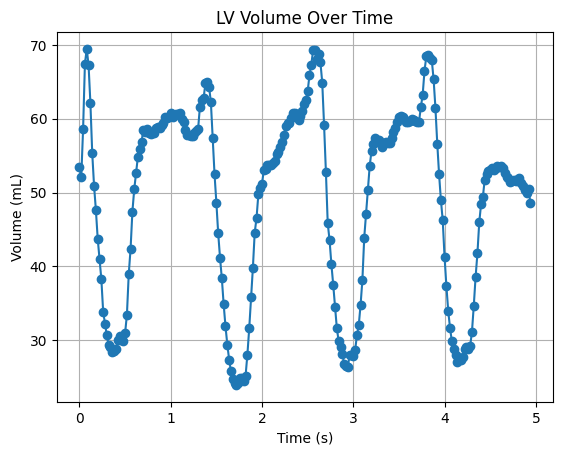

Segmentations saved to: ./assets/demo_2.avi
Estimated EDV: 194.83 mL, ESV: 43.37 mL, EF: 77.74%


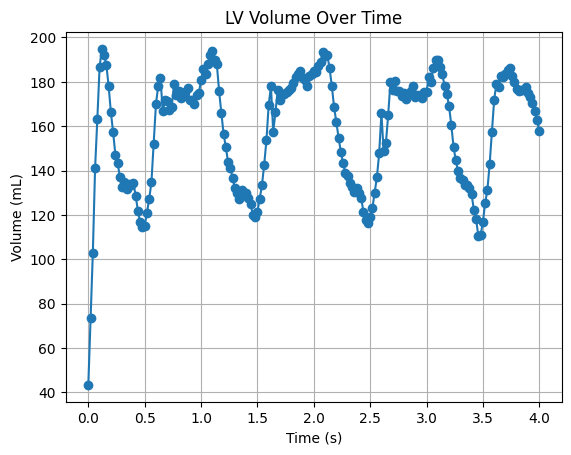

Segmentations saved to: ./assets/demo_3.avi
Estimated EDV: 77.56 mL, ESV: 13.64 mL, EF: 82.41%


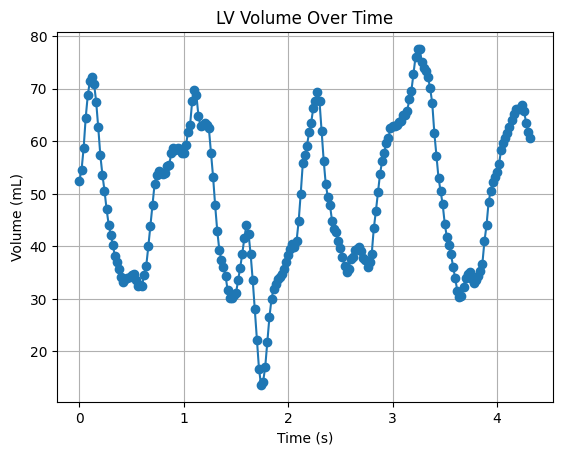

Segmentations saved to: ./assets/demo_4.avi
Estimated EDV: 152.94 mL, ESV: 51.60 mL, EF: 66.26%


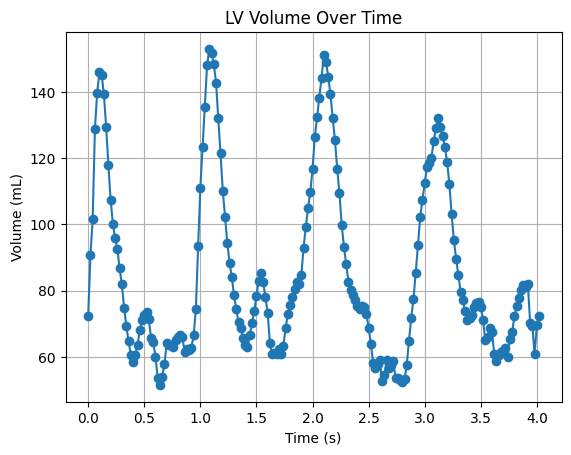

Segmentations saved to: ./assets/demo_5.avi
Estimated EDV: 106.39 mL, ESV: 33.74 mL, EF: 68.29%


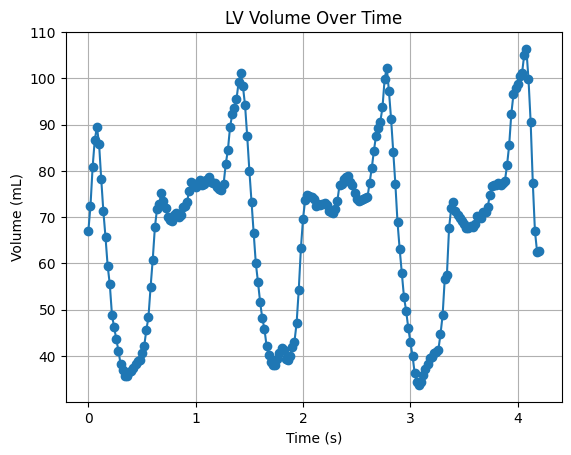

In [7]:
model = MobileNetV3UNet3D()
for idx,path in enumerate(videos_path_list):
    segment_video_demo_2(video_path=path,
                    model=model,
                    model_path=model_path_1,
                    device='cuda',
                    save_path=f'./assets/demo_{idx+1}.avi',
                    plot_volume=True,
                    fps=50,
                    )